In [519]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [520]:
# Visualization Parameters

labelFormatOut = {'size':20, 'weight':'bold', 'labelpad':20, 'fontname':'Tw Cen MT'}
labelFormat = {'size':20, 'weight':'bold', 'fontname':'Tw Cen MT'}
valueFormat = {'size':10, 'fontname':'Tw Cen MT'}
titleValueFormat = {'size':10, 'weight':'bold', 'fontname':'Tw Cen MT'}
titleFormat = {'size':30, 'weight':'bold', 'y':1.03, 'fontname':'Tw Cen MT'}
titleFormatMinis = {'size':15, 'weight':'bold', 'y':1.03, 'fontname':'Tw Cen MT'}
customTickColor = '#2A2D34'
snsCustomPallete=['#0E7C7B', '#4B1D3F', '#D62246', '#17BEBB']
cColorRed = '#E7122B'
cColorBlue = '#2BA3D4'

In [521]:
file_path = '../RiceDatathon/OilData.csv'
test_path ='../RiceDatathon/scoring.csv'
data = pd.read_csv(file_path)
test_data = pd.read_csv(test_path)


In [522]:
data_cleaned = data.dropna(subset=['OilPeakRate'])
data_cleaned.drop(columns="Unnamed: 0", inplace=True)

data_with_oilpeak = data_cleaned.copy()
data_without_oilpeak = data_cleaned[data_cleaned['OilPeakRate'].isnull()].copy()

for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype == 'object':
            mode_value = data[column].mode()[0]
        else:
            median_value = data[column].median()

        data_with_oilpeak[column].fillna(mode_value if data[column].dtype == 'object' else median_value, inplace=True)
        data_without_oilpeak[column].fillna(mode_value if data[column].dtype == 'object' else median_value, inplace=True)

threshold = 50
columns_to_drop = data_with_oilpeak.columns[data_with_oilpeak.isnull().mean() > threshold / 100]
data_with_oilpeak.drop(columns=columns_to_drop, inplace=True)

numeric_cols = data_with_oilpeak.select_dtypes(include=['number']).columns
Q1 = data_with_oilpeak[numeric_cols].quantile(0.25)
Q3 = data_with_oilpeak[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (data_with_oilpeak[numeric_cols] < (Q1 - 1.5 * IQR)) | (data_with_oilpeak[numeric_cols] > (Q3 + 1.5 * IQR))
data_with_oilpeak_reduced = data_with_oilpeak[~outlier_mask.any(axis=1)]

target_data = data_with_oilpeak_reduced[['OilPeakRate']].copy()
target_variable = "OilPeakRate"
data_with_oilpeak_reduced.drop(columns=['OilPeakRate'], inplace=True)

print("Shape of target data:", target_data.shape)
print("Shape of features data:", data_with_oilpeak_reduced.shape)

Shape of target data: (12490, 1)
Shape of features data: (12490, 29)


In [523]:
for column in test_data.columns:
    if test_data[column].isnull().sum() > 0:
        if test_data[column].dtype == 'object':
            mode_value = test_data[column].mode()[0]
            test_data[column].fillna(mode_value, inplace=True)
        else:
            median_value = test_data[column].median()
            test_data[column].fillna(median_value, inplace=True)

threshold = 50
columns_to_drop = test_data.columns[test_data.isnull().mean() > threshold / 100]
test_data1 = test_data.drop(columns=columns_to_drop)

# # Remove outliers
# numeric_cols = test_data.select_dtypes(include=['number']).columns
# Q1 = test_data[numeric_cols].quantile(0.25)
# Q3 = test_data[numeric_cols].quantile(0.75)
# IQR = Q3 - Q1
# outlier_mask = (test_data[numeric_cols] < (Q1 - 1.5 * IQR)) | (test_data[numeric_cols] > (Q3 + 1.5 * IQR))
# test_data_reduced = test_data[~outlier_mask.any(axis=1)]

test_data1.info()
print("Shape of cleaned test data:", test_data1.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    400 non-null    int64  
 1   surface_x                     400 non-null    float64
 2   surface_y                     400 non-null    float64
 3   bh_x                          400 non-null    float64
 4   bh_y                          400 non-null    float64
 5   standardized_operator_name    400 non-null    int64  
 6   gross_perforated_length       400 non-null    float64
 7   number_of_stages              400 non-null    float64
 8   total_proppant                400 non-null    float64
 9   total_fluid                   400 non-null    float64
 10  true_vertical_depth           400 non-null    float64
 11  ffs_frac_type                 400 non-null    object 
 12  proppant_intensity            400 non-null    float64
 13  frac_

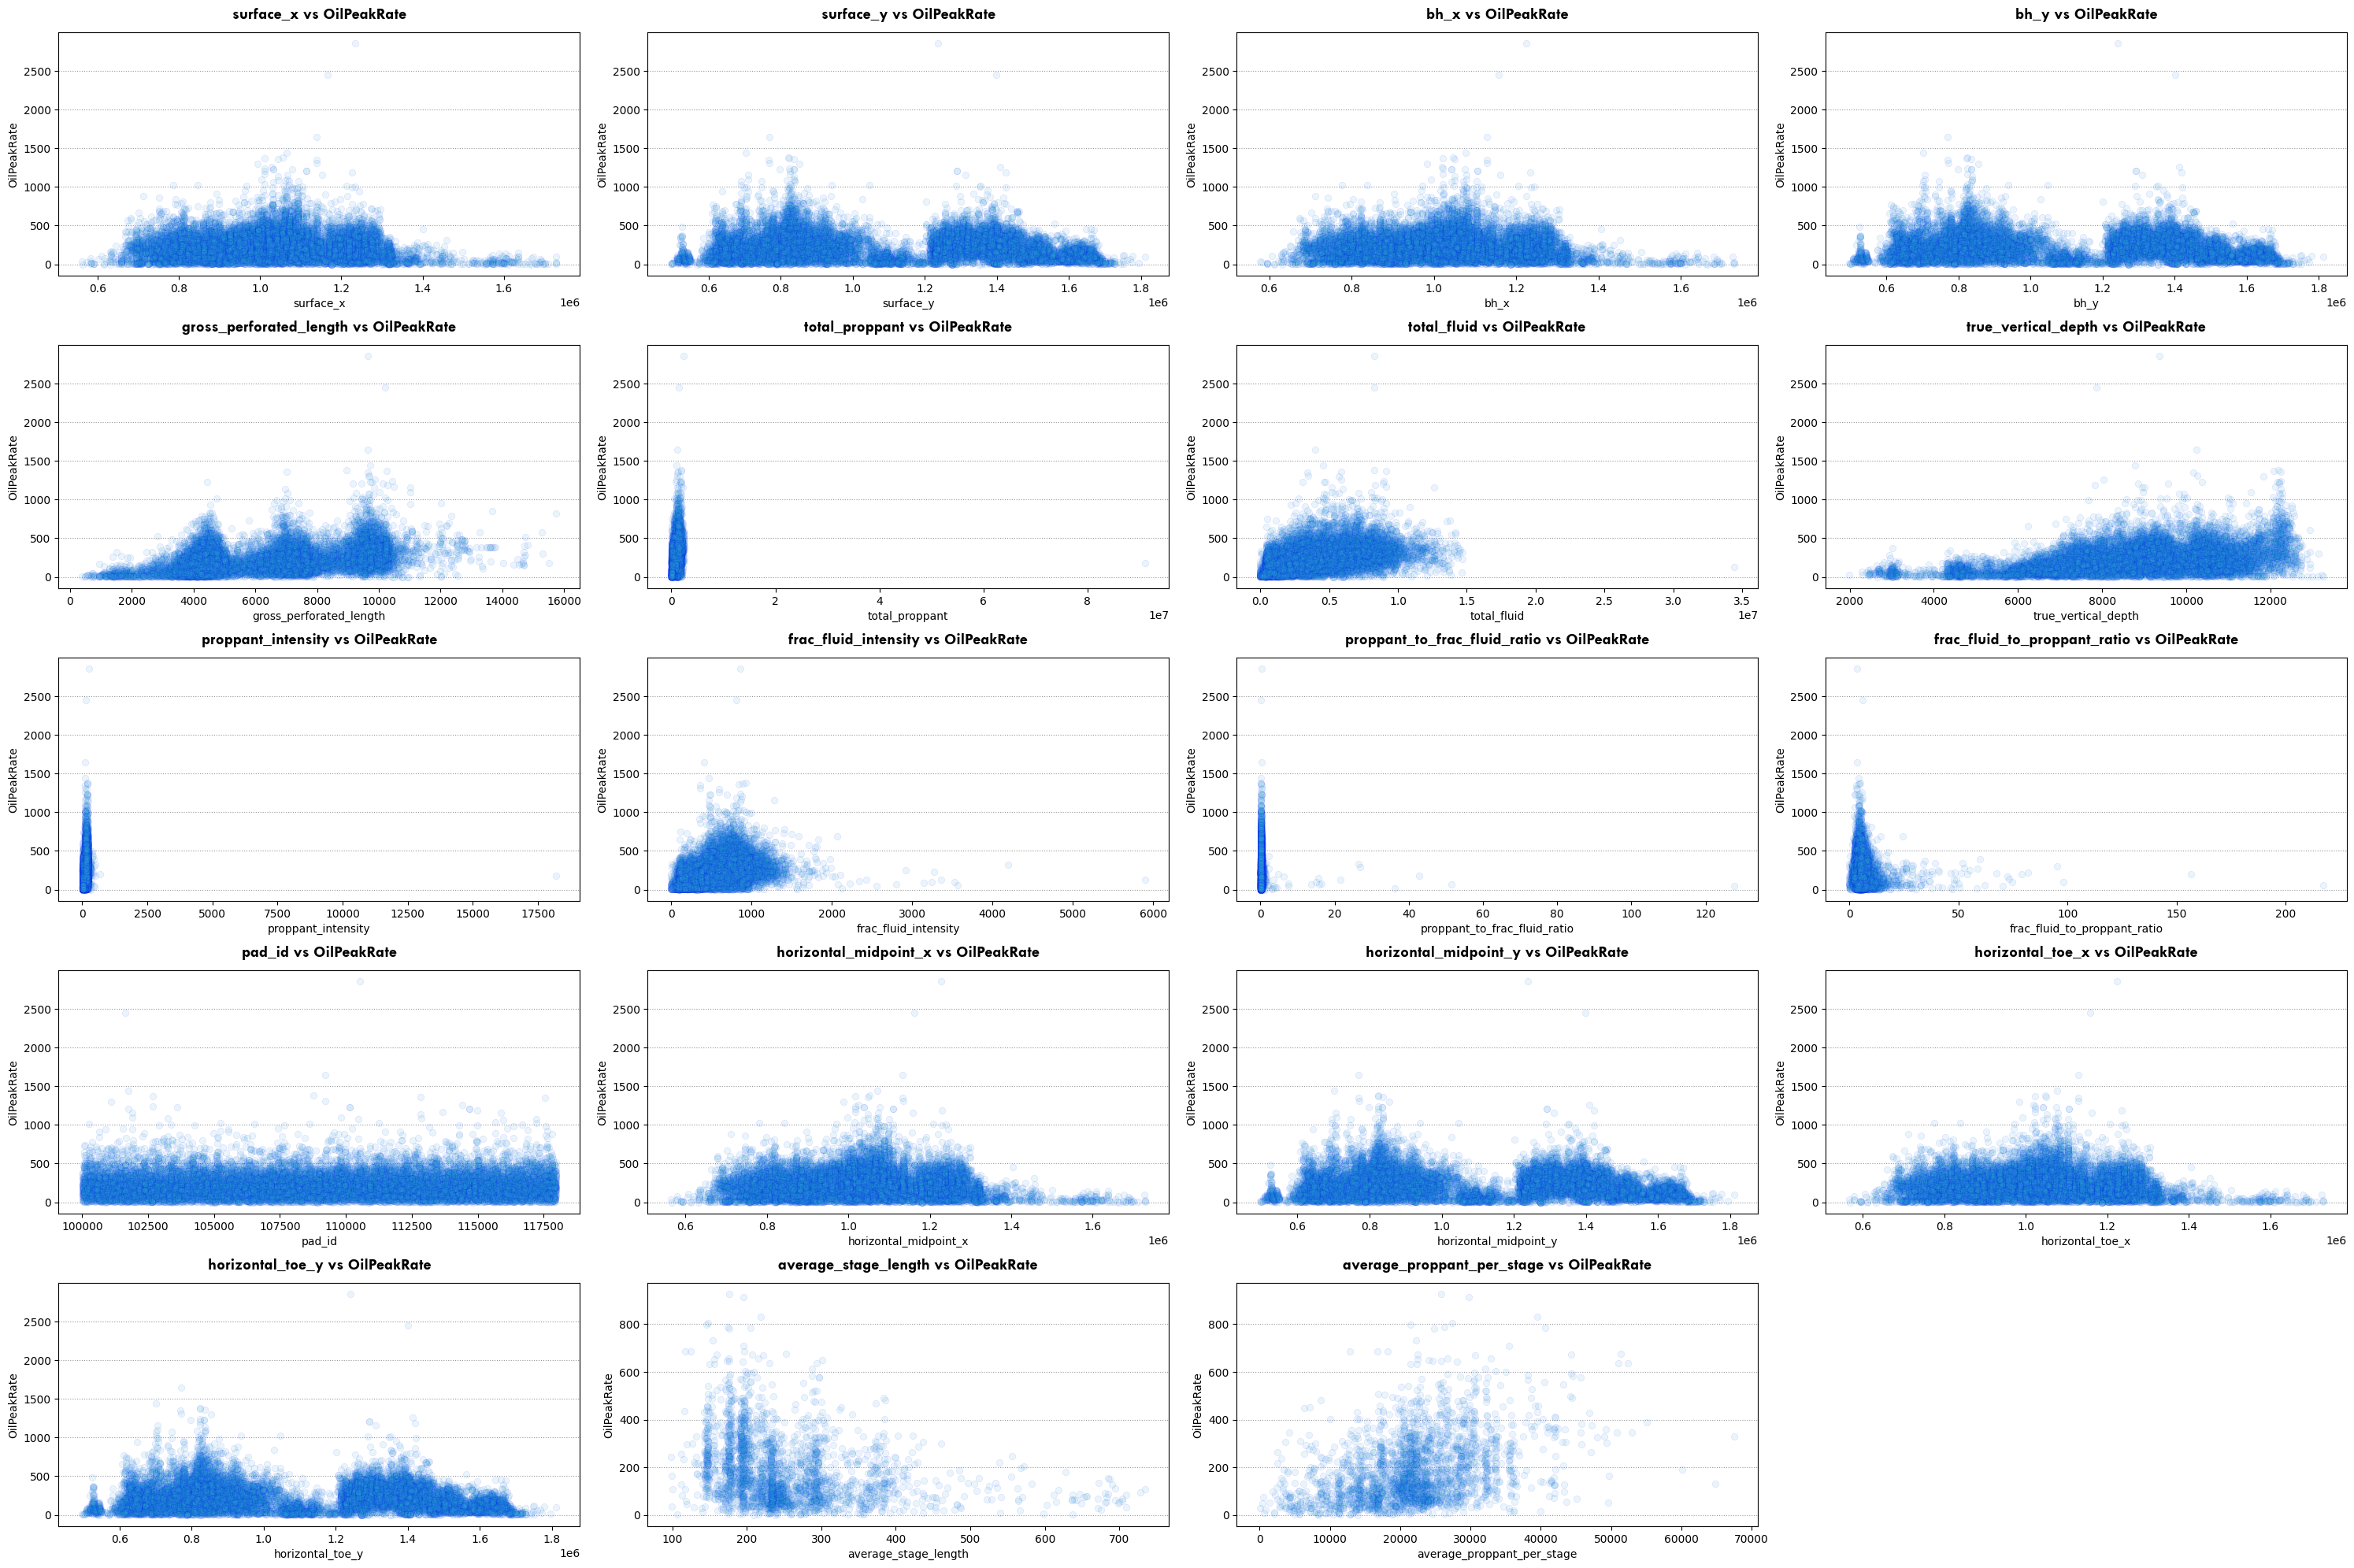

In [524]:
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y',
                     'horizontal_toe_x','horizontal_toe_y','average_stage_length','average_proppant_per_stage','average_frac_fluid_per_stage'] 

plt.figure(figsize=(30, 20))

for i, column in enumerate(numerical_columns[:-1], 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=data_cleaned[column], y=data_cleaned[target_variable], alpha=0.1, edgecolors='b', color=cColorBlue)
    plt.title(f'{column} vs {target_variable}', **titleFormatMinis)
    
    #Adds background
    ax = plt.subplot(5, 4, i)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color=customTickColor, alpha=0.5, linestyle='dotted')

plt.tight_layout()
plt.show()

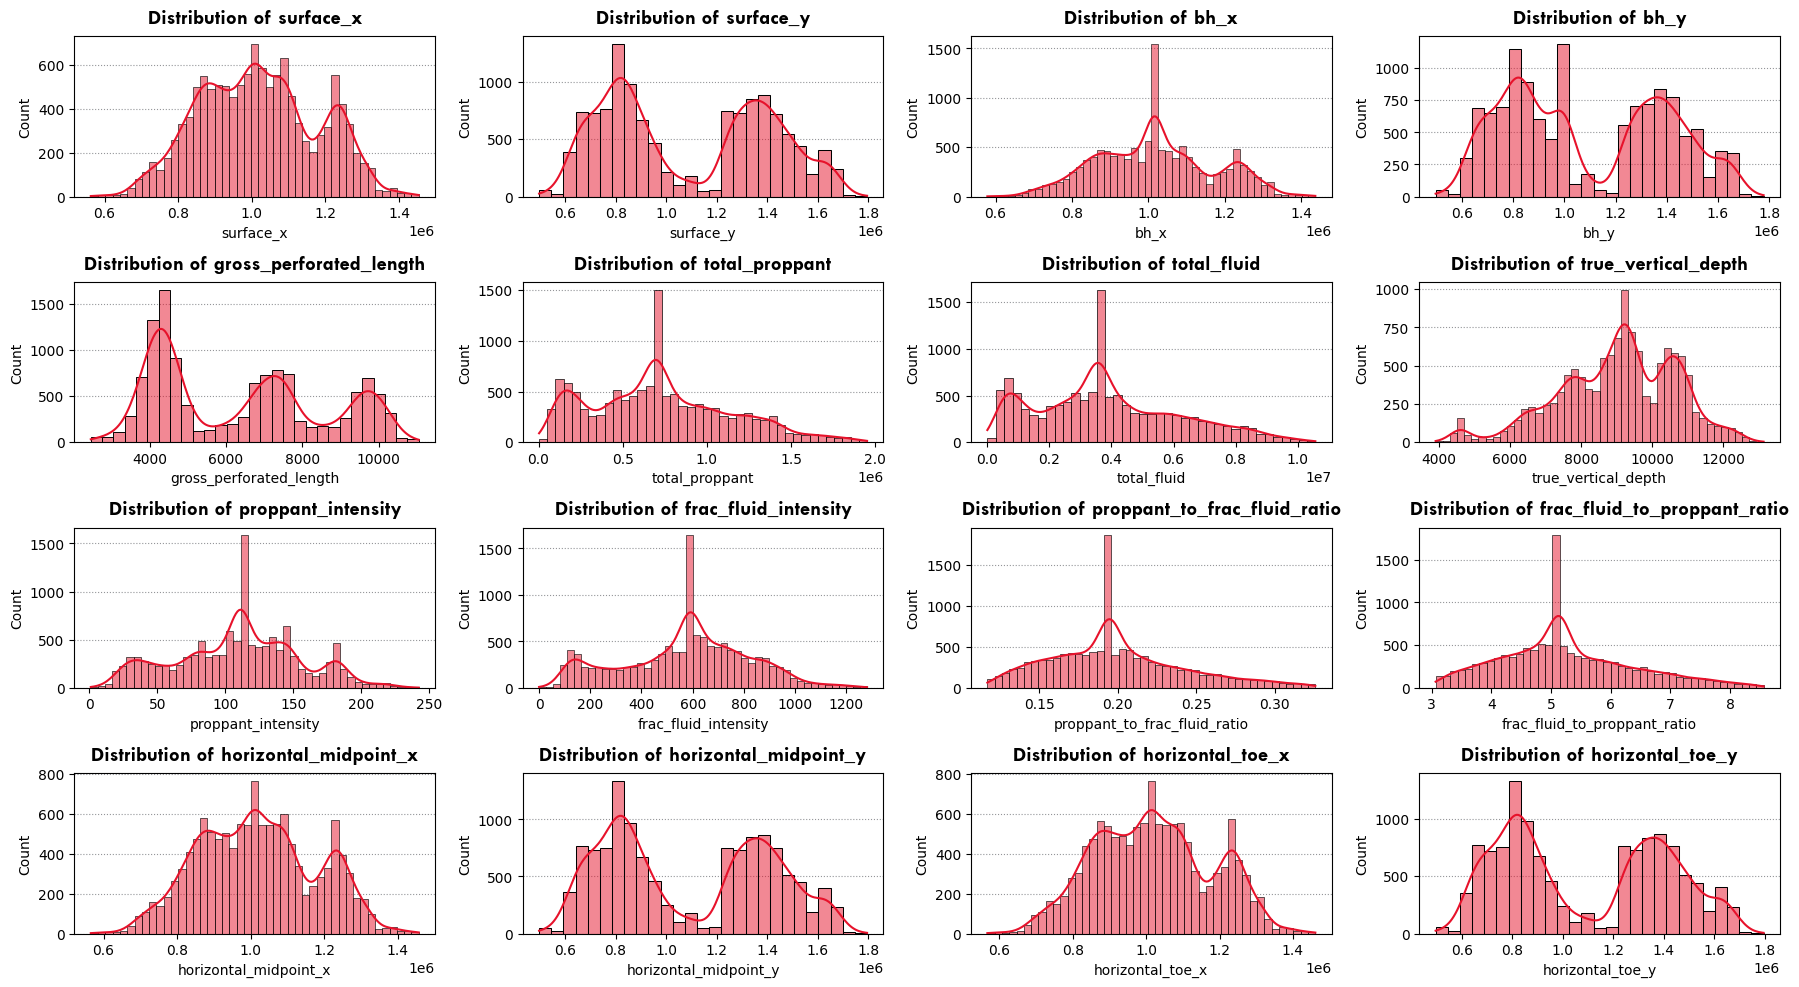

In [525]:
data_with_oilpeak_reduced = data_with_oilpeak_reduced.drop(columns=['average_stage_length','average_proppant_per_stage','average_frac_fluid_per_stage','pad_id'])
test_data1_reduced = test_data1.drop(columns=['average_stage_length','average_proppant_per_stage','average_frac_fluid_per_stage','pad_id'])

numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y'] 
plt.figure(figsize=(18, 12))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data_with_oilpeak_reduced[column], kde=True, color = cColorRed)
    plt.title(f'Distribution of {column}', **titleFormatMinis)
    
    #Adds background
    ax = plt.subplot(5, 4, i)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color=customTickColor, alpha=0.5, linestyle='dotted')
    
plt.tight_layout()
plt.show()

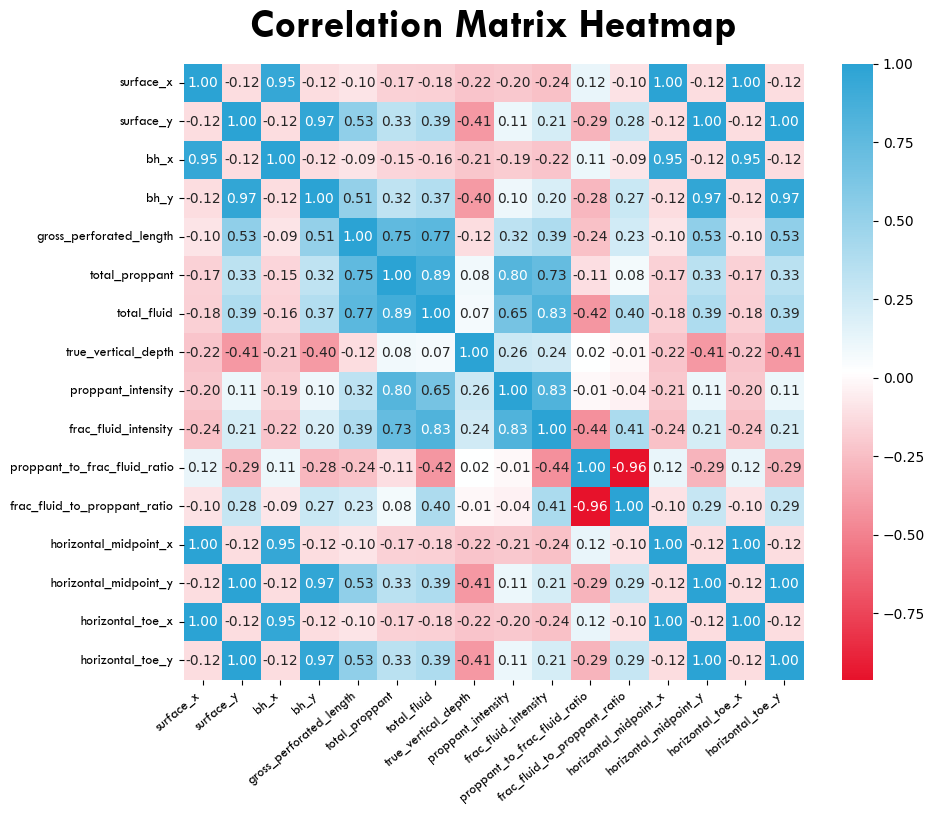

In [526]:
cCmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cColorRed,"white",cColorBlue])
corr_matrix = data_with_oilpeak_reduced[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=cCmap, fmt='.2f')
plt.title('Correlation Matrix Heatmap', **titleFormat)
plt.xticks(**valueFormat, rotation=40, ha='right')
plt.yticks(**valueFormat)
plt.show()

In [527]:
surface_coordinates = data_with_oilpeak_reduced[['surface_x', 'surface_y']]
kmeans_surface = KMeans(n_clusters=4)
surface_clusters = kmeans_surface.fit_predict(surface_coordinates)
data_with_oilpeak_reduced['surface_cluster'] = surface_clusters

bh_coordinates = data_with_oilpeak_reduced[['bh_x', 'bh_y']]
kmeans_bh = KMeans(n_clusters=4)
bh_clusters = kmeans_bh.fit_predict(bh_coordinates)
data_with_oilpeak_reduced['bh_cluster'] = bh_clusters

mid_coordinates = data_with_oilpeak_reduced[['horizontal_midpoint_x', 'horizontal_midpoint_y']]
kmeans_mid = KMeans(n_clusters=4)
mid_clusters = kmeans_mid.fit_predict(mid_coordinates)
data_with_oilpeak_reduced['mid_clusters'] = mid_clusters

toe_coordinates = data_with_oilpeak_reduced[['horizontal_toe_x', 'horizontal_toe_y']]
kmeans_toe = KMeans(n_clusters=4)
toe_clusters = kmeans_toe.fit_predict(toe_coordinates)
data_with_oilpeak_reduced['toe_clusters'] = toe_clusters

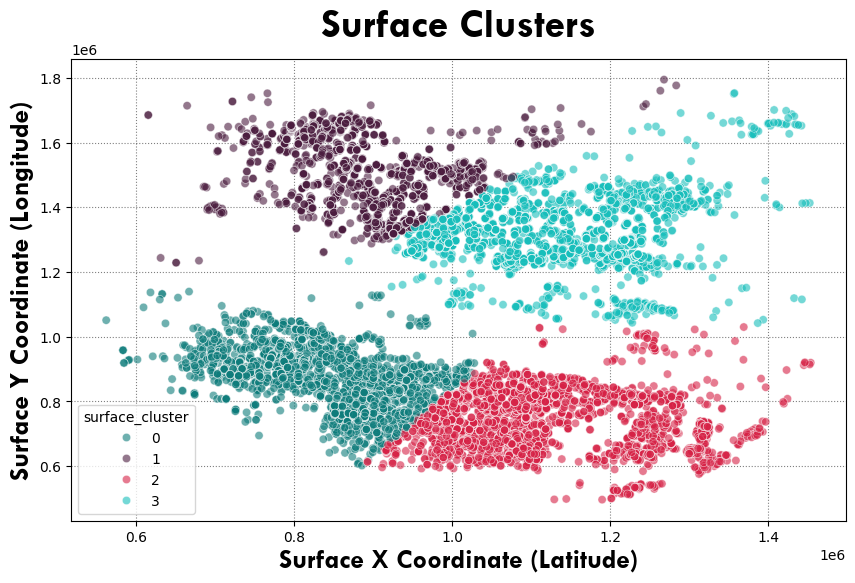

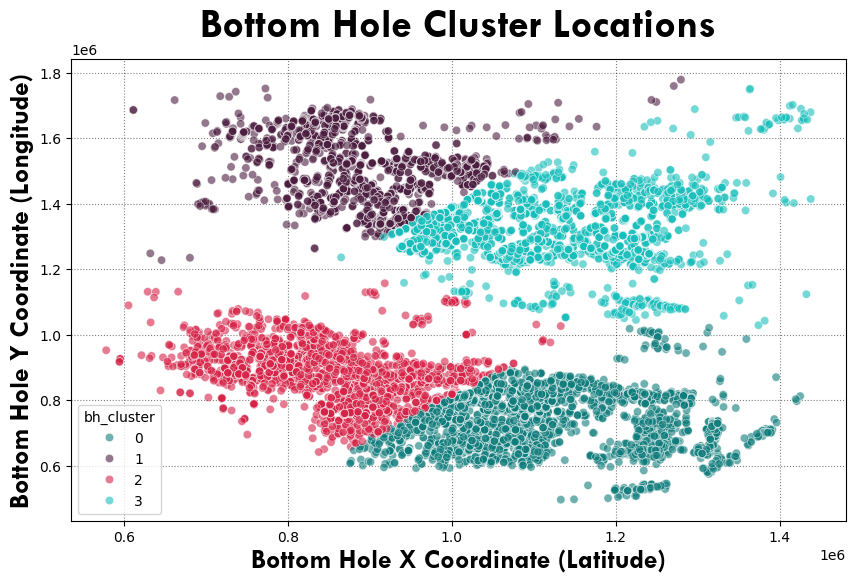

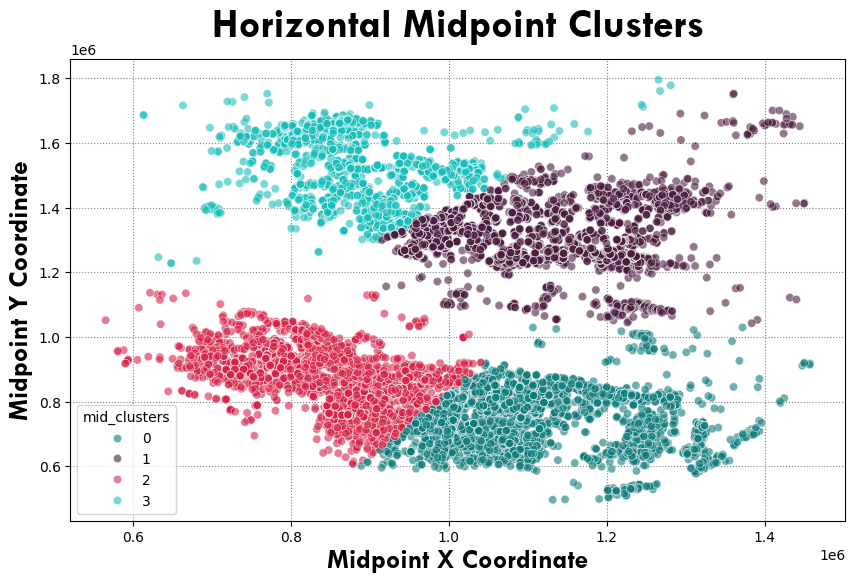

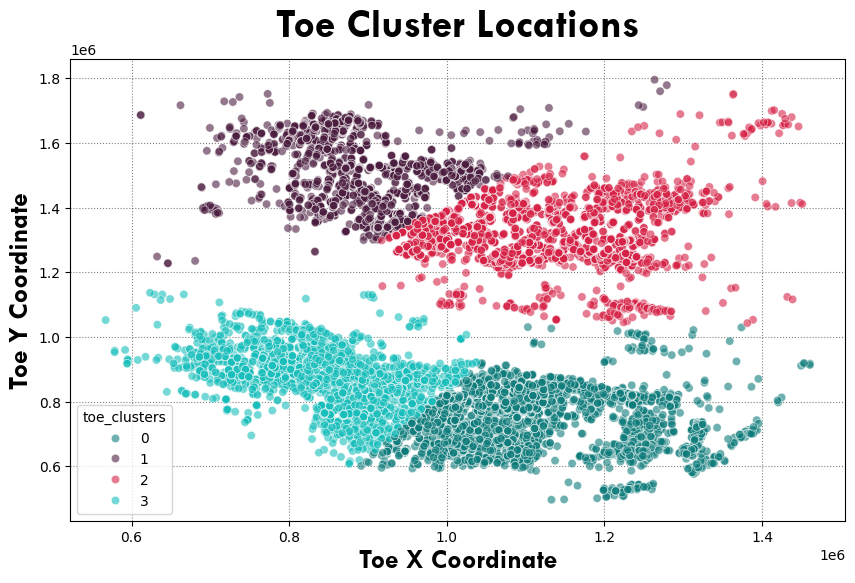

In [528]:
# snsCustomPallete

plt.figure(figsize=(10, 6))
sns.scatterplot(x='surface_x', y='surface_y', hue='surface_cluster', data=data_with_oilpeak_reduced, palette=snsCustomPallete, alpha=0.6)
plt.title('Surface Clusters', **titleFormat)
plt.xlabel('Surface X Coordinate (Latitude)', **labelFormat)
plt.ylabel('Surface Y Coordinate (Longitude)', **labelFormat)

ax = plt.subplot()
ax.set_axisbelow(True)
ax.xaxis.grid(color='black', alpha=0.5, linestyle='dotted')
ax.yaxis.grid(color='black', alpha=0.5, linestyle='dotted')

plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bh_x', y='bh_y', hue='bh_cluster', data=data_with_oilpeak_reduced, palette=snsCustomPallete, alpha=0.6)
plt.title('Bottom Hole Cluster Locations', **titleFormat)
plt.xlabel('Bottom Hole X Coordinate (Latitude)', **labelFormat)
plt.ylabel('Bottom Hole Y Coordinate (Longitude)', **labelFormat)

ax = plt.subplot()
ax.set_axisbelow(True)
ax.xaxis.grid(color='black', alpha=0.5, linestyle='dotted')
ax.yaxis.grid(color='black', alpha=0.5, linestyle='dotted')

plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_midpoint_x', y='horizontal_midpoint_y', hue='mid_clusters', data=data_with_oilpeak_reduced, palette=snsCustomPallete, alpha=0.6)
plt.title('Horizontal Midpoint Clusters', **titleFormat)
plt.xlabel('Midpoint X Coordinate', **labelFormat)
plt.ylabel('Midpoint Y Coordinate', **labelFormat)

ax = plt.subplot()
ax.set_axisbelow(True)
ax.xaxis.grid(color='black', alpha=0.5, linestyle='dotted')
ax.yaxis.grid(color='black', alpha=0.5, linestyle='dotted')

plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_toe_x', y='horizontal_toe_y', hue='toe_clusters', data=data_with_oilpeak_reduced, palette=snsCustomPallete, alpha=0.6)
plt.title('Toe Cluster Locations', **titleFormat)
plt.xlabel('Toe X Coordinate', **labelFormat)
plt.ylabel('Toe Y Coordinate', **labelFormat)

ax = plt.subplot()
ax.set_axisbelow(True)
ax.xaxis.grid(color='black', alpha=0.5, linestyle='dotted')
ax.yaxis.grid(color='black', alpha=0.5, linestyle='dotted')

plt.show()

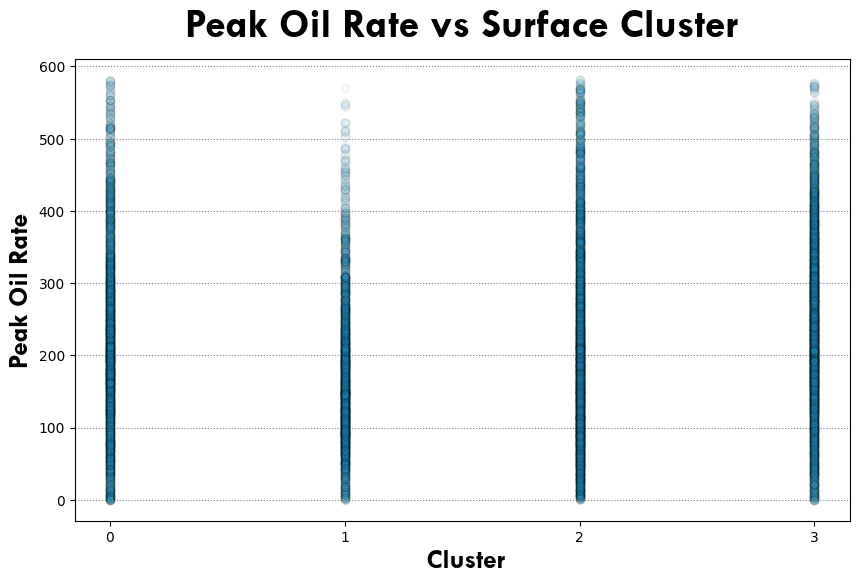

In [529]:
x = data_with_oilpeak_reduced['surface_cluster']
y = target_data[target_variable]

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', color=cColorBlue, alpha=0.05, markeredgecolor='black') 
plt.xlabel(' Cluster', **labelFormat)
plt.ylabel('Peak Oil Rate', **labelFormat)
plt.title('Peak Oil Rate vs Surface Cluster', **titleFormat)
# plt.xticks(rotation=30)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

ax = plt.subplot()
ax.set_axisbelow(True)
# ax.xaxis.grid(color='black', alpha=0.5, linestyle='dotted')
ax.yaxis.grid(color='black', alpha=0.5, linestyle='dotted')

plt.show()

In [530]:
data_with_cluster = data_with_oilpeak_reduced.drop(columns=["bh_x","bh_y","bh_cluster","mid_clusters",
                                                       "toe_clusters","horizontal_midpoint_x","horizontal_midpoint_y",
                                                       "horizontal_toe_x","horizontal_toe_y","surface_cluster"])


test_data_cluster = test_data1_reduced.drop(columns=["bh_x","bh_y","horizontal_midpoint_x","horizontal_midpoint_y",
                                                    "horizontal_toe_x","horizontal_toe_y"])

# data_with_cluster.info()
# print(data_with_cluster.shape)

In [531]:
categorical_cols = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship', 'frac_type']

for col in categorical_cols:
    le = LabelEncoder()
    data_with_cluster[col] = le.fit_transform(data_with_cluster[col])

Y = target_data['OilPeakRate']
X = data_with_cluster.drop(columns=['number_of_stages'])

infinite_cols = X.columns.to_series()[np.isinf(X).any()]

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = X.fillna(X.median())

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            OilPeakRate   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     430.6
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        07:33:50   Log-Likelihood:                -75187.
No. Observations:               12490   AIC:                         1.504e+05
Df Residuals:                   12472   BIC:                         1.505e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [532]:
categorical_cols = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship', 'frac_type']
for col in categorical_cols:
    le = LabelEncoder()
    test_data_cluster[col] = le.fit_transform(test_data_cluster[col])

# Y = target_data['OilPeakRate']    
test_1 = test_data_cluster.drop(columns=['number_of_stages'])

infinite_cols = test_1.columns.to_series()[np.isinf(test_1).any()]

test_1.replace([np.inf, -np.inf], np.nan, inplace=True)

test_1 = test_1.fillna(test_1.median())

test_1 = sm.add_constant(test_1)
test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   const                         400 non-null    float64
 1   Unnamed: 0                    400 non-null    int64  
 2   surface_x                     400 non-null    float64
 3   surface_y                     400 non-null    float64
 4   standardized_operator_name    400 non-null    int64  
 5   gross_perforated_length       400 non-null    float64
 6   total_proppant                400 non-null    float64
 7   total_fluid                   400 non-null    float64
 8   true_vertical_depth           400 non-null    float64
 9   ffs_frac_type                 400 non-null    int32  
 10  proppant_intensity            400 non-null    float64
 11  frac_fluid_intensity          400 non-null    float64
 12  proppant_to_frac_fluid_ratio  400 non-null    float64
 13  frac_

In [533]:
def forward_selection(X, Y, significance_level=0.01):
    initial_features = X.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(Y, sm.add_constant(X[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

selected_features = forward_selection(X, Y)
# print("Selected features:", selected_features)

X_selected = sm.add_constant(X[selected_features])
model = sm.OLS(Y, X_selected).fit()
# print(model.summary())

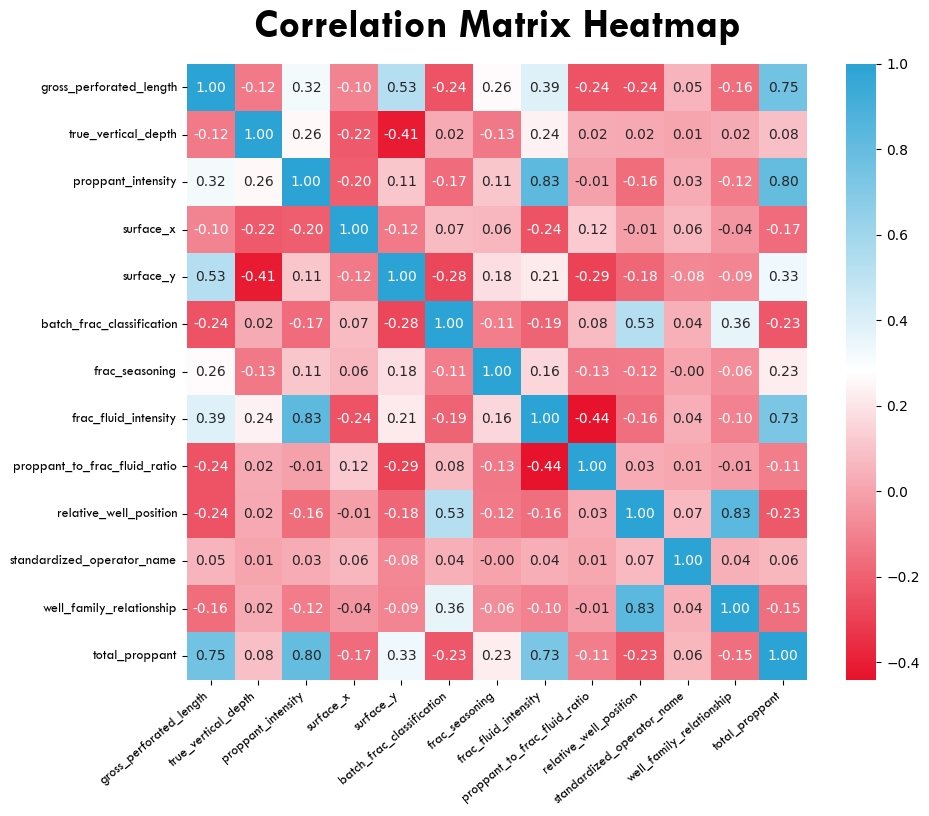

In [534]:
cCmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cColorRed,"white",cColorBlue])
corr_matrix = X_selected.drop(columns='const').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=cCmap, fmt='.2f')
plt.title('Correlation Matrix Heatmap', **titleFormat)
plt.xticks(**valueFormat, rotation=40, ha='right')
plt.yticks(**valueFormat)
plt.show()


In [535]:
x_final = X_selected.drop(columns=['total_proppant',"well_family_relationship"]) # Correlated with other things, got rid off
X_train, X_test, y_train, y_test = train_test_split(x_final, Y, test_size=0.07, random_state=0)

# random_forest_model = RandomForestRegressor(random_state=0)

# param_grid = {
#     'n_estimators': [100],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt'],
# }

# param_grid = {
#     'n_estimators': [100],
#     'max_depth': [30],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'max_features': ['sqrt'],
#     'min_impurity_decrease': [0.11],
#     'ccp_alpha': [0.2, 0.5, 1.0, 2.0]
# }

# grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_

best_params = {
    'n_estimators': 300,
    'max_depth': 15,
    'min_samples_split': 2,
    'min_samples_leaf': 3,
    'max_features': .5,
    'min_impurity_decrease': 0.11,
    'ccp_alpha': 0.2
}

print(best_params)


best_rf_model = RandomForestRegressor(**best_params, random_state=0)

num_folds = 5

cv_scores = cross_val_score(best_rf_model, X_selected, Y, cv=num_folds, scoring='neg_root_mean_squared_error')

cv_rmse_scores = -cv_scores

average_cv_rmse = np.mean(cv_rmse_scores)
std_dev_cv_rmse = np.std(cv_rmse_scores)

print("Average CV RMSE:", average_cv_rmse)
print("Standard Deviation of CV RMSE:", std_dev_cv_rmse)

best_rf_model.fit(X_train, y_train)

y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print(comparison_df.head())

{'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.5, 'min_impurity_decrease': 0.11, 'ccp_alpha': 0.2}
Average CV RMSE: 100.38453795901246
Standard Deviation of CV RMSE: 7.803553361571016
Training RMSE: 57.71387038099387
Testing RMSE: 79.66243489776772
           Actual   Predicted
14620  202.557968  258.906587
11968  479.709258  386.224862
16070  233.678608  279.396442
1003    76.353328   57.582255
2265   409.607206  373.773184


In [536]:
test_2 = test_1.drop(columns=['total_proppant',"well_family_relationship"])


final_features = x_final.columns
test_data_aligned = test_2.reindex(columns=final_features)

extra_columns = [col for col in test_2.columns if col not in final_features]
if extra_columns:
    test_2.drop(columns=extra_columns, inplace=True)

test_2 = test_2[final_features]

test_predictions = best_rf_model.predict(test_2)

predictions_df = pd.DataFrame(test_predictions, columns=['OilPeakRate'])

predictions_df.to_csv('TeamPeak_Submission_file.csv', index=False)